In [6]:
# import statements and functions to clean columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import tqdm
import folium
from collections import Counter
%matplotlib inline
pd.set_option('display.max_columns', None)

drop_cols = ['wpt_name', 'recorded_by']
columns_to_keep = ['id',
                   'date_recorded',
                   'amount_tsh', 
                   'gps_height', 
                   'latitude', 
                   'longitude', 
                   'basin',
                   'lga',
                   'population',
                   'permit',
                   'extraction_type',
                   'management',
                   'payment',
                   'water_quality',
                   'quantity',
                   'source',
                   'waterpoint_type']

numeric_columns = ['date_recorded', 
                   'amount_tsh', 
                   'gps_height', 
                   'population', 
                   'permit', 
                   'payment', 
                   'water_quality', 
                   'quantity', 'source', 
                   'status_group']

statuses = {'functional':1, 'functional needs repair':2, 'non functional':3}

status_decoder = {1:'functional', 2:'functional needs repair', 3:'non functional'}

def encode_quality(x):
    if x == 'soft':
        return 1
    else:
        return 0

def encode_tsh(x):
    if x > 250:
        return 2
    elif x > 0:
        return 1
    else:
        return 0
    
def encode_date_recorded(date):
    if date < dt.date(month=6, day=1, year=2011):
        return 1
    elif date < dt.date(month=2, day=1, year=2012):
        return 2
    elif date < dt.date(month=1, day=1, year=2013):
        return 3
    elif date < dt.date(month=4, day=10, year=2013):
        return 4
    elif date >= dt.date(month=4, day=10, year=2013):
        return 5
    else:
        return 0
    
def encode_quantity(quantity):
    if quantity == 'enough':
        return 2
    if quantity == 'insufficient':
        return 1
    else:
        return 0
    
def encode_payment(payment):
    if payment == 'never pay':
        return 0
    elif payment == 'pay annually':
        return 1
    elif payment == 'pay monthly':
        return 2
    elif payment == 'pay per bucket':
        return 3
    else:
        return -1
    
def encode_source(source):
    if source == 'hand dtw':
        return -3
    elif source == 'shallow well':
        return -2
    elif source == 'spring':
        return -1
    elif source == 'rainwater harvesting':
        return 1
    else:
        return 0
    
def encode_extraction_type(x):
    if x in ['nira/tanira', 'swn 80', 'india mark ii', 'india mark iii', 'afridev', 
             'other - rope pump', 'swn 81', 'other - play pump', 'walimi']:
        return 'human'

    elif x in  ['submersible', 'mono', 'ksb','cemo','climax', 'other - mkulima/shinyanga']:
        return 'power'

    elif x in ['windmill', 'gravity']:
        return 'nature'
    
    else:
        return 'unknown'

In [2]:
# function to load and clean data

def load_data(separate=False):
    X = pd.read_csv('training_values.csv')
    y = pd.read_csv('training_labels.csv')
    
    # encode statuses
    #y['status'] = y.status_group.apply(lambda x: statuses[x])
    
    # encode tsh
    X.amount_tsh = X.amount_tsh.apply(encode_tsh)
    
    # modify gps_height to one-hot
    X.gps_height = X.gps_height.apply(lambda x: int(x != 0))
    
    # convert date_recorded to datetime 'phase'
    X.date_recorded = pd.to_datetime(X.date_recorded, errors='coerce')
    X.date_recorded = X.date_recorded.apply(encode_date_recorded)
    
    # set known permits equal to 1, all else equal to 1
    X.permit = X.permit.apply(lambda x: 1 if x else 0)
    
    # set water quality to 1 for 'known to be good' and 0 otherwise
    X.water_quality = X.water_quality.apply(lambda x: int(x == 'soft'))
    
    # encode quantity: 2 for 'enough', 1 for 'insufficient', 0 for everything else
    X.quantity = X.quantity.apply(encode_quantity)
    
    # encode payment in terms of 'number of payments per year' (or -1 if unknown)
    X.payment = X.payment.apply(encode_payment)
    
    # encode source (negative: underground. 0: surface. positive: above ground)
    X.source = X.source.apply(encode_source)
    
    # encode extraction type: hand, powered, or nature
    X.extraction_type = X.extraction_type.apply(encode_extraction_type)
    X = X[columns_to_keep]
    
    if separate:
        return X, y
    
    else:
        return pd.merge(X, y, left_on='id', right_on='id')

load_data(separate=False).head(2)

,id,date_recorded,amount_tsh,gps_height,latitude,longitude,basin,lga,population,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group
0,69572,1,2,1,-9.856322,34.938093,Lake Nyasa,Ludewa,109,0,nature,vwc,1,1,2,-1,communal standpipe,functional
1,8776,4,0,1,-2.147466,34.698766,Lake Victoria,Serengeti,280,1,nature,wug,0,1,1,1,communal standpipe,functional


In [3]:
df = pd.read_csv('tanzania_water_pump.csv')

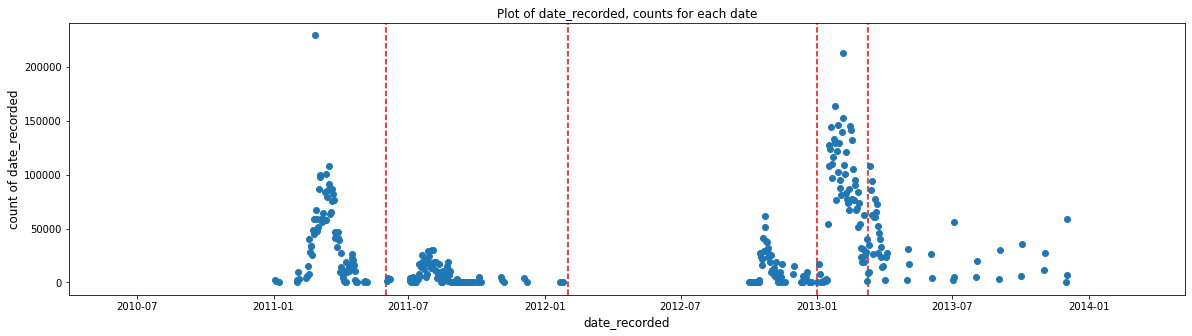

In [5]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
population = df.groupby('date_recorded', as_index = False).agg({"population": "sum"})
plt.figure(figsize=(20,5))
plt.title('Plot of date_recorded, counts for each date')
plt.ylabel('count of date_recorded', fontsize=12)
plt.xlabel('date_recorded', fontsize=12)
plt.xlim(14700, 16200)
plt.axvline(dt.date(month=6, day=1, year=2011), ymin=0, ymax=1, color='r', linestyle='--')
plt.axvline(dt.date(month=2, day=1, year=2012), ymin=0, ymax=1, color='r', linestyle='--')
plt.axvline(dt.date(month=1, day=1, year=2013), ymin=0, ymax=1, color='r', linestyle='--')
plt.axvline(dt.date(month=3, day=10, year=2013), ymin=0, ymax=1, color='r', linestyle='--')
plt.plot_date(population.date_recorded, population.population)

plt.show()

In [ ]:
def load_dummies():
    return pd.get_dummies(data=load_data(), 
                          columns=['date_recorded', 'amount_tsh', 'gps_height', 'basin', 'lga', 
                                   'extraction_type', 'management', 'payment', 'quantity', 
                                   'source', 'waterpoint_type'])

load_dummies()

In [8]:
def load_dummies2():
    return pd.get_dummies(data=load_data().drop('id', axis=1), columns=['basin', 
                                                                        'lga', 
                                                                        'extraction_type', 
                                                                        'management', 
                                                                        'waterpoint_type'])
load_dummies2()

,date_recorded,amount_tsh,gps_height,latitude,longitude,population,permit,payment,water_quality,quantity,source,status_group,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,lga_Arusha Rural,lga_Arusha Urban,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Kongwa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Monduli,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Rungwe,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,extraction_type_human,extraction_type_nature,extraction_type_power,extraction_type_unknown,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,1,2,1,-9.856322,34.938093,109,0,1,1,2,-1,functional,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,4,0,1,-2.147466,34.698766,280,1,0,1,1,1,functional,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,4,1,1,-3.821329,37.460664,250,1,3,1,2,0,functional,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,4,0,1,-11.155298,38.486161,58,1,0,1,0,0,non functional,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,2,0,0,-1.825359,31.130847,0,1,0,1,0,1,functional,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [9]:
from sklearn.model_selection import train_test_split
df = load_dummies2()
X = df.drop('status_group', axis=1)
y = df.status_group.apply(lambda x: statuses[x])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
#dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10)
#dt.fit(X_train, y_train)
#y_pred = dt.predict(X_test)
#print(accuracy_score(y_test, y_pred))
#plot_confusion_matrix(dt, X_test, y_test, cmap='Blues')

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'criterion':['gini', 'entropy'],
    'splitter':['best'],
    'max_depth':[5, 10, 15],
    'min_samples_split':[2, 3, 5, 7],
    'min_samples_leaf':[1]
}

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, make_scorer

def get_false_positives(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[2][0]

fp_scorer = make_scorer(get_false_positives, greater_is_better=False)

gs_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=6, scoring=fp_scorer)
gs_tree.fit(X_train, y_train)
gs_tree.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1695.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1666.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1778.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1611.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1685.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1695.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1667.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1778.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1611.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1685.000, total=   0.2s
[CV] criterion=gini, max_depth

[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1291.000, total=   0.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1159.000, total=   0.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1164.000, total=   0.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1126.000, total=   0.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1243.000, total=   0.5s
[CV] criterion=gini, 

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1628.000, total=   0.4s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2, splitter=best 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1447.000, total=   0.4s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2, splitter=best 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1505.000, total=   0.4s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1485.000, total=   0.4s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1428.000, total=  

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   47.6s finished


{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

0.7585858585858586
0.3169819621645403


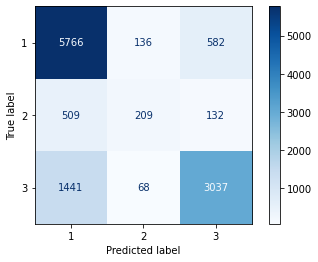

In [17]:
# one-hotted data
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, make_scorer

def get_false_positives(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[2][0]

fp_scorer = make_scorer(get_false_positives)
dt = DecisionTreeClassifier(**gs_tree.best_params_)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm[2][0] / sum(cm[2][i] for i in range(3)))
plot_confusion_matrix(dt, X_test, y_test, cmap='Blues')

In [ ]:
param_grid = {
    'max_depth':[5, 10, 15],
    'min_samples_split':[2, 3, 5, 7],
    'min_samples_leaf':[1, 3, 5, 7]
}

def get_false_positives(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[2][0]

list = [('max_depth', 'min_samples_split', 'min_samples_leaf', 'false_positives')]

for max_depth in [5, 10, 15]:
    for min_samples_split in [2, 3, 5, 7]:
        for min_samples_leaf in [1, 3, 5, 7]:
            dt = DecisionTreeClassifier(max_depth=20, min_samples_split=3, min_samples_leaf=7)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)

0.7588383838383839


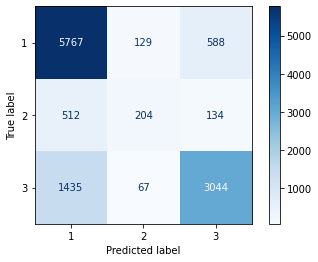

In [13]:
y_test_pred = dt.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
plot_confusion_matrix(dt, X_test, y_test, cmap='Blues')

In [19]:
print(dt.tree_)

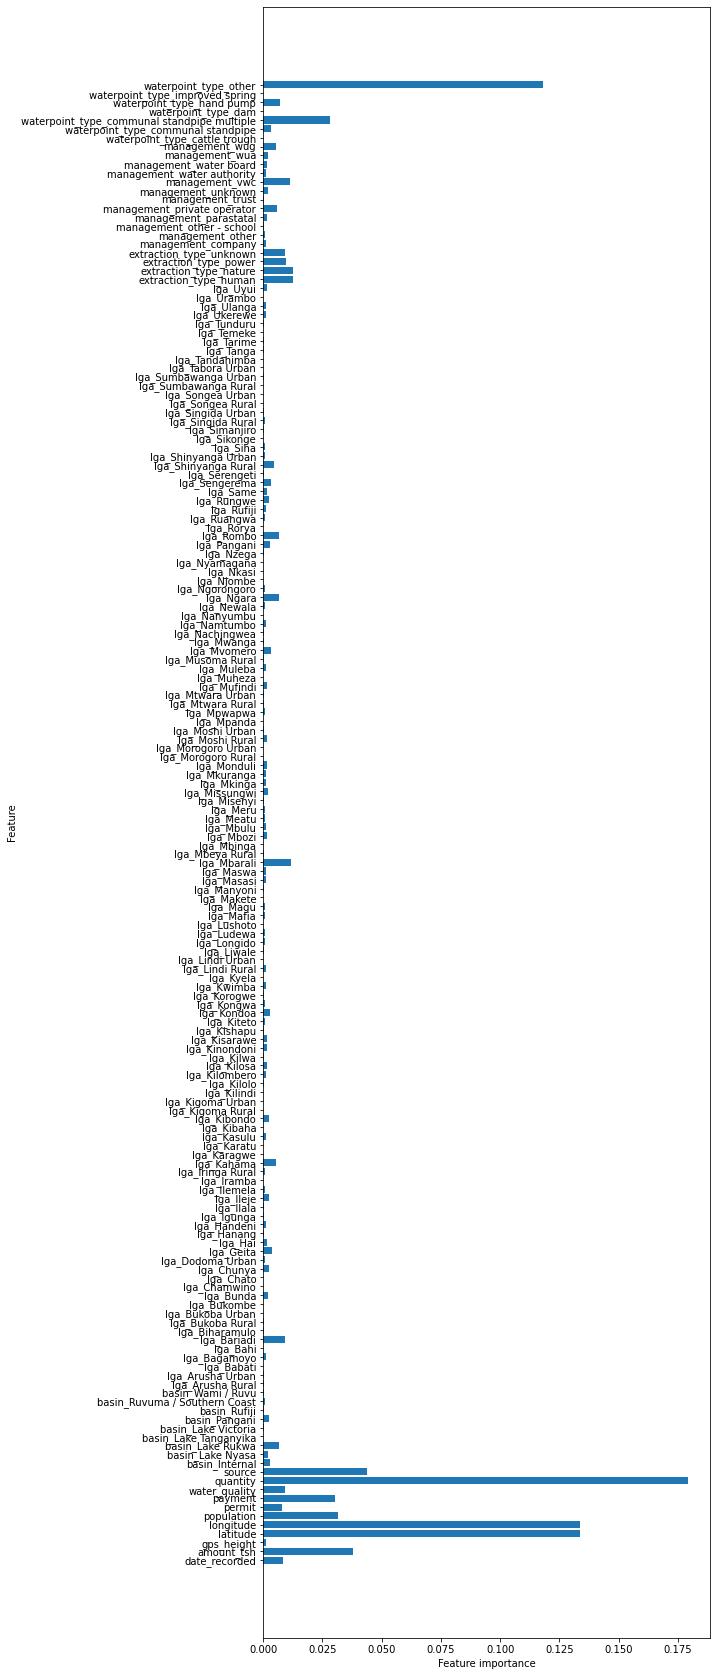

In [20]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,30))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(dt)

In [22]:
dt.feature_importances_

array([8.54442834e-03, 3.77657011e-02, 1.06057814e-03, 1.33811463e-01,
       1.33682778e-01, 3.16969336e-02, 7.79037127e-03, 3.05079072e-02,
       9.19899907e-03, 1.79406118e-01, 4.38817403e-02, 2.98670355e-03,
       2.14087847e-03, 6.65304351e-03, 2.45045493e-05, 2.54956114e-04,
       2.45909707e-03, 1.33938535e-04, 5.95012606e-04, 5.11938074e-04,
       3.41406675e-04, 1.40635462e-04, 0.00000000e+00, 1.30321047e-03,
       0.00000000e+00, 9.37208343e-03, 2.73625114e-04, 1.96311639e-04,
       0.00000000e+00, 0.00000000e+00, 1.85064830e-03, 0.00000000e+00,
       0.00000000e+00, 2.62724336e-03, 8.71401656e-04, 3.75241707e-03,
       1.55103349e-03, 2.59929407e-04, 1.09737378e-03, 2.53390043e-04,
       5.08227227e-04, 2.37762332e-03, 6.70907898e-04, 1.20664699e-04,
       6.13581823e-04, 5.39752156e-03, 0.00000000e+00, 0.00000000e+00,
       1.04707412e-03, 0.00000000e+00, 2.48925830e-03, 7.36661945e-05,
       0.00000000e+00, 2.82493842e-05, 4.59400201e-04, 1.09499076e-03,
      